In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow.keras.backend as K

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def load_images_from_folder(folder, image_size=(64, 64)):
    images = []
    for filename in glob(os.path.join(folder, '*')):
        img = load_img(filename, target_size=image_size)
        img = img_to_array(img)
        img = (img - 127.5) / 127.5  # Normalize to [-1, 1]
        images.append(img)
    return np.array(images)

In [5]:
# Load images
folder_path = '/content/drive/My Drive/train/train'  # Change this to your folder path
image_data = load_images_from_folder(folder_path)

In [6]:
# Clear previous TensorFlow session to free up memory
K.clear_session()

# Enable mixed precision to optimize memory usage
tf.keras.mixed_precision.set_global_policy('mixed_float16')


In [7]:
# MODEL 1

In [8]:
# Define generator
def build_generator(latent_dim):
    model = keras.Sequential([
        layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(latent_dim,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Reshape((8, 8, 256)),
        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', activation='tanh', kernel_initializer='he_normal')
    ])
    model.summary()
    return model

In [9]:
# Define discriminator
def build_discriminator(image_shape):
    model = keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=image_shape),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    model.summary()
    return model

In [10]:
# Loss functions
def generator_loss(fake_output):
    return tf.keras.losses.BinaryCrossentropy(from_logits=False)(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

In [11]:
# Training function
def train_dcgan(generator, discriminator, dataset, epochs=50, batch_size=64, latent_dim=100):
    generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    dataset = tf.data.Dataset.from_tensor_slices(dataset).shuffle(1000).batch(batch_size)

    for epoch in range(epochs):
        for real_images in dataset:
          #Generate Random Noise
            noise = tf.random.normal([batch_size, latent_dim])

          # Compute Fake and Real Images
            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_images = generator(noise, training=True)

                real_output = discriminator(real_images, training=True)
                fake_output = discriminator(fake_images, training=True)

          # Compute Loss
                gen_loss = generator_loss(fake_output)
                disc_loss = discriminator_loss(real_output, fake_output)


          # Compute Gradients
            gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
            disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

          # Update Model Parameters
            generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

        print(f"Epoch {epoch + 1}, Gen Loss: {gen_loss.numpy()}, Disc Loss: {disc_loss.numpy()}")



In [12]:
# Set parameters
latent_dim = 100
image_shape = (64, 64, 3)

generator = build_generator(latent_dim)
discriminator = build_discriminator(image_shape)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16384)               │       1,638,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16384)               │          65,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 128)         │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 64)          │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 64, 64, 3)           │           4,803 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,733,507 (10.43 MB)

 Trainable params: 2,700,355 (10.30 MB)

 Non-trainable params: 33,152 (129.50 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │          32,769 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 242,561 (947.50 KB)

 Trainable params: 242,561 (947.50 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Train DCGAN
train_dcgan(generator, discriminator, image_data, epochs=50)

Epoch 1, Gen Loss: 0.7395060062408447, Disc Loss: 1.2242740392684937
Epoch 2, Gen Loss: 0.9670323133468628, Disc Loss: 0.8611023426055908
Epoch 3, Gen Loss: 1.3713107109069824, Disc Loss: 0.5276249647140503
Epoch 4, Gen Loss: 1.6960828304290771, Disc Loss: 0.33154556155204773
Epoch 5, Gen Loss: 1.9906015396118164, Disc Loss: 0.22928738594055176
Epoch 6, Gen Loss: 2.493610382080078, Disc Loss: 0.1384582817554474
Epoch 7, Gen Loss: 2.8116977214813232, Disc Loss: 0.098269984126091
Epoch 8, Gen Loss: 2.7645931243896484, Disc Loss: 0.0886305421590805
Epoch 9, Gen Loss: 2.8568716049194336, Disc Loss: 0.08687571436166763
Epoch 10, Gen Loss: 3.251072883605957, Disc Loss: 0.06373526155948639
Epoch 11, Gen Loss: 3.4528541564941406, Disc Loss: 0.05546814948320389
Epoch 12, Gen Loss: 3.7350010871887207, Disc Loss: 0.037311725318431854
Epoch 13, Gen Loss: 4.022347450256348, Disc Loss: 0.03370990604162216
Epoch 14, Gen Loss: 4.029364585876465, Disc Loss: 0.028171779587864876
Epoch 15, Gen Loss: 4.16

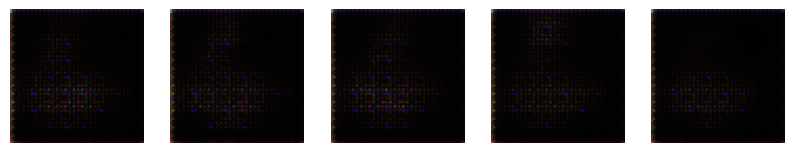

In [14]:
def generate_and_save_images(model, num_images=5):
    noise = tf.random.normal([num_images, latent_dim])
    generated_images = model(noise, training=False).numpy()  # Convert to NumPy array

    generated_images = (generated_images * 255).astype(np.uint8)  # Scale to [0, 255] for imshow

    fig, axs = plt.subplots(1, num_images, figsize=(10, 10))
    for i in range(num_images):
        axs[i].imshow(generated_images[i])  # Show image
        axs[i].axis('off')
    plt.show()

generate_and_save_images(generator)


In [15]:
# MODEL 2

Epoch 1, Gen Loss: 0.7530868649482727, Disc Loss: 1.166071891784668
Epoch 2, Gen Loss: 0.9972557425498962, Disc Loss: 0.7794719338417053
Epoch 3, Gen Loss: 1.5499038696289062, Disc Loss: 0.4312892556190491
Epoch 4, Gen Loss: 2.5568079948425293, Disc Loss: 0.14063596725463867
Epoch 5, Gen Loss: 3.609666347503662, Disc Loss: 0.07206054776906967
Epoch 6, Gen Loss: 4.181405067443848, Disc Loss: 0.03436288237571716
Epoch 7, Gen Loss: 4.583157539367676, Disc Loss: 0.02202182449400425
Epoch 8, Gen Loss: 4.834812164306641, Disc Loss: 0.015510204248130322
Epoch 9, Gen Loss: 5.056077003479004, Disc Loss: 0.007819018326699734
Epoch 10, Gen Loss: 5.29056453704834, Disc Loss: 0.008438490331172943
Epoch 11, Gen Loss: 5.408862590789795, Disc Loss: 0.007843753322958946
Epoch 12, Gen Loss: 5.534704208374023, Disc Loss: 0.00547886872664094
Epoch 13, Gen Loss: 5.626795768737793, Disc Loss: 0.005036480724811554
Epoch 14, Gen Loss: 5.718259811401367, Disc Loss: 0.005210693925619125
Epoch 15, Gen Loss: 5.74

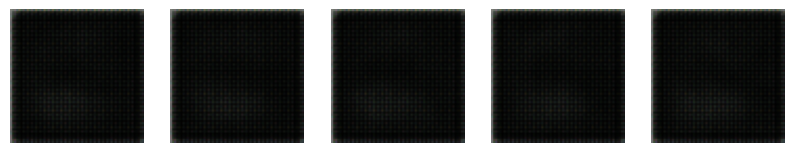

In [16]:
# Define generator
def build_generator(latent_dim):
    model = keras.Sequential([
        layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(latent_dim,), kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Reshape((8, 8, 256)),
        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', activation='sigmoid', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02))
    ])
    return model

# Define discriminator
def build_discriminator(image_shape):
    model = keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=image_shape, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Loss functions
def generator_loss(fake_output):
    return tf.keras.losses.BinaryCrossentropy(from_logits=False)(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

# Training function
def train_dcgan(generator, discriminator, dataset, epochs=50, batch_size=64, latent_dim=100):
    generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    dataset = tf.data.Dataset.from_tensor_slices(dataset).shuffle(1000).batch(batch_size)

    for epoch in range(epochs):
        for real_images in dataset:
            noise = tf.random.normal([batch_size, latent_dim])

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_images = generator(noise, training=True)

                real_output = discriminator(real_images, training=True)
                fake_output = discriminator(fake_images, training=True)

                gen_loss = generator_loss(fake_output)
                disc_loss = discriminator_loss(real_output, fake_output)

            gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
            disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

        print(f"Epoch {epoch + 1}, Gen Loss: {gen_loss.numpy()}, Disc Loss: {disc_loss.numpy()}")

# Set parameters
latent_dim = 100
image_shape = (64, 64, 3)

generator = build_generator(latent_dim)
discriminator = build_discriminator(image_shape)

# Train DCGAN
train_dcgan(generator, discriminator, image_data, epochs=50)

def generate_and_save_images(model, num_images=5):
    noise = tf.random.normal([num_images, latent_dim])
    generated_images = model(noise, training=False).numpy()  # Convert to NumPy array

    generated_images = (generated_images * 255).astype(np.uint8)  # Scale to [0, 255] for imshow

    fig, axs = plt.subplots(1, num_images, figsize=(10, 10))
    for i in range(num_images):
        axs[i].imshow(generated_images[i])  # Show image
        axs[i].axis('off')
    plt.show()

generate_and_save_images(generator)


In [17]:
# MODEL 3

Epoch 1, Gen Loss: -0.14013671875, Disc Loss: 1.876953125
Epoch 2, Gen Loss: -0.27685546875, Disc Loss: 1.7138671875
Epoch 3, Gen Loss: -0.261962890625, Disc Loss: 1.4326171875
Epoch 4, Gen Loss: -0.11639404296875, Disc Loss: 1.12890625
Epoch 5, Gen Loss: 0.08563232421875, Disc Loss: 0.9326171875
Epoch 6, Gen Loss: 0.2183837890625, Disc Loss: 0.83544921875
Epoch 7, Gen Loss: 0.1724853515625, Disc Loss: 0.84326171875
Epoch 8, Gen Loss: 0.1990966796875, Disc Loss: 0.88623046875
Epoch 9, Gen Loss: 0.04852294921875, Disc Loss: 0.96435546875
Epoch 10, Gen Loss: -0.077880859375, Disc Loss: 1.26953125
Epoch 11, Gen Loss: -0.07379150390625, Disc Loss: 1.0791015625
Epoch 12, Gen Loss: 0.3984375, Disc Loss: 0.8203125
Epoch 13, Gen Loss: 0.66259765625, Disc Loss: 0.391357421875
Epoch 14, Gen Loss: 0.80615234375, Disc Loss: 0.44140625
Epoch 15, Gen Loss: 0.7890625, Disc Loss: 0.482177734375
Epoch 16, Gen Loss: 0.67431640625, Disc Loss: 0.75927734375
Epoch 17, Gen Loss: 0.513671875, Disc Loss: 0.89

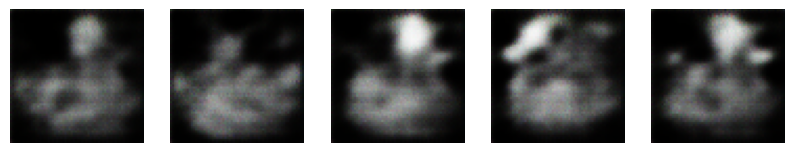

In [18]:
# Define generator
def build_generator(latent_dim):
    model = keras.Sequential([
        layers.Dense(8 * 8 * 512, use_bias=False, input_shape=(latent_dim,), kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Reshape((8, 8, 512)),
        layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', activation='tanh', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02))
    ])
    return model

# Define discriminator
def build_discriminator(image_shape):
    model = keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=image_shape, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1, activation='linear')
    ])
    return model

# Loss functions
def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = tf.reduce_mean(tf.nn.relu(1.0 - real_output))
    fake_loss = tf.reduce_mean(tf.nn.relu(1.0 + fake_output))
    return real_loss + fake_loss

# Training function
def train_dcgan(generator, discriminator, dataset, epochs=100, batch_size=64, latent_dim=100):
    generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

    dataset = tf.data.Dataset.from_tensor_slices(dataset).shuffle(1000).batch(batch_size)

    for epoch in range(epochs):
        for real_images in dataset:
            noise = tf.random.normal([batch_size, latent_dim])

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_images = generator(noise, training=True)

                real_output = discriminator(real_images, training=True)
                fake_output = discriminator(fake_images, training=True)

                gen_loss = generator_loss(fake_output)
                disc_loss = discriminator_loss(real_output, fake_output)

            gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
            disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

        print(f"Epoch {epoch + 1}, Gen Loss: {gen_loss.numpy()}, Disc Loss: {disc_loss.numpy()}")

# Set parameters
latent_dim = 100
image_shape = (64, 64, 3)

generator = build_generator(latent_dim)
discriminator = build_discriminator(image_shape)

# Train DCGAN
train_dcgan(generator, discriminator, image_data, epochs=100)

# Generate and visualize new images
def generate_and_save_images(model, num_images=5):
    noise = tf.random.normal([num_images, latent_dim])
    generated_images = model(noise, training=False)
    generated_images = (generated_images.numpy() * 127.5 + 127.5).astype(np.uint8)  # Convert back to [0, 255]

    fig, axs = plt.subplots(1, num_images, figsize=(10, 10))
    for i in range(num_images):
        axs[i].imshow(generated_images[i])
        axs[i].axis('off')
    plt.show()

generate_and_save_images(generator)
